# Sentiment Analysis using LDA with PCA and Stopwords Removal

In [1]:
#Libraries
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords  # List of common words usually ignored in text analysis
#from nltk.stem.porter import PorterStemmer  # For stemming using the Porter algorithm
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

## 1. Dataset

In [2]:
imdb_dataset = pd.read_csv('C:/Users/Nosse/IMDBDataset.csv') #load data
print(imdb_dataset.shape)

(50000, 2)


## 2. Review Text Pre-Processing : Cleaning Text & StopWords

In this section, we perform comprehensive text preprocessing to prepare the dataset for topic modeling and classification. As in the previous notebook, we apply several key steps: `HTML tag removal`, `special character filtering`, `tokenization`, `text normalization`, and `stemming`, which reduces words to their root forms (e.g., “running” → “run”) to unify similar terms and reduce vocabulary size.

A notable enhancement in this notebook is the **removal of stopwords**, which are common, non-informative words (such as “the”, “and”, “is”) that do not contribute significantly to sentiment or topic structure.



### 2.1 Remove HTML tags & Noise from the text

In [3]:
#remove html from text
def remove_html(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    ss = BeautifulSoup(text, "html.parser")
    return ss.get_text()
    
#remove text between square brackets
def remove_btw_square_bb(text):
    return re.sub(r'\[[^]]*\]','',text)

#call all the function to clean text
def remove_noise_txt(text):
    text = remove_html(text)
    text = remove_btw_square_bb(text)
    return text

#apply the function
imdb_dataset['review']= imdb_dataset['review'].apply(remove_noise_txt)


#### Explanation:

1. **Removing HTML from text**: the function *remove_html(text)* uses BeautifulSoup to parse HTML content from the given text and extract only text without the tags. Useful fro cleaning reviews that may contain HTML tags.
   
2. **Removing text bewtween square brackets**: the function *remove_btw_square_bb(text)* utilizes a regex (regular expression), to find and remove (replace) any text that appears between square brackets, this helps to eliminate irrelevant information.
   
3. **Removing Noise from text**: the function  *remove_noise_txt(text)* combines the two previous functions, first remove HTML tags and then eliminates text that is enclosed in square brackets.

### 2.2 Removing special CHR

In [4]:
#Function to remove special chr with regex
def remove_sp_CHR(text, remove_digits=True):
    pattern= r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Function call
imdb_dataset['review']= imdb_dataset['review'].apply(remove_sp_CHR)

#### Explanation: 

In this step, we define a function `remove_sp_CHR` that uses regular expressions (`regex`) to clean the text data. Specifically, it removes **special characters**, preserving only alphanumeric characters and whitespace. The pattern `[^a-zA-Z0-9\s]` matches any character that is **not** a letter, digit, or space, and replaces it with an empty string. This function is applied to each review in the dataset to ensure the text is cleaner and more consistent for subsequent processing.

### 2.3 Null or Duplicate values Detection (columns - rows)

In [5]:
null_var_column = imdb_dataset.isnull().sum() #null values in dataset
print("Null values - each column: \n",null_var_column)

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)

Null values - each column: 
 review       0
sentiment    0
dtype: int64

 Duplicates -  rows: 
 419



**NOTE**:

In this study, **duplicate entries are intentionally retained** in the dataset to preserve a perfectly balanced distribution between sentiment classes. By maintaining the duplicates, we ensure an equal number of **25,000 positive** and **25,000 negative** reviews. This balance helps prevent bias in model training and evaluation, allowing for fairer comparisons and more reliable performance metrics during sentiment classification.


### 2.4 Text Normalization & Tokenization

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

#download  stop-words
nltk.download('stopwords')

#Tokenization
tokenizer = ToktokTokenizer()

#List of stop-words
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nosse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NLTK Import and Stopword Download**
The code begins by importing the NLTK (Natural Language Toolkit) library, a widely used toolkit for natural language processing. It also downloads the English stopwords set  a collection of frequently occurring words like "and," "is," and "that" which are usually excluded during preprocessing due to their limited contribution to text meaning.

**Tokenizing the Text**
A tokenizer instance using ToktokTokenizer is created. Tokenization refers to splitting the text into smaller components (typically words or phrases), facilitating easier analysis and manipulation.

**Setting English Stopwords**
Using NLTK, the code defines a list of English stopwords. This enables the model to filter out these commonly used terms that don't add significant value to sentiment interpretation.

### 2.5 Optimization : Text Stemming

Stemming is a text preprocessing technique used in Natural Language Processing (NLP) to reduce words to their root or base form, known as the stem. The goal is to treat words with similar meanings (such as "running", "runs", "ran") as a single term, thereby improving the efficiency and effectiveness of text analysis.

In [7]:
#Stemming Function
def stem_txt(txt):
    Ps = nltk.porter.PorterStemmer()
    txt = ' '.join([Ps.stem(word) for word in txt.split()])
    return txt

#Apply f
imdb_dataset['review']=imdb_dataset['review'].apply(stem_txt)



**Stem_txt** : this function applies stemming to a given text using the **Porter Stemmer** from the NLTK library.
Splits the input text into individual words,applies stemming to each word using the **stem()** method.
After all, rebuilds the list of stemmed words into a single string and returns the processed (stemmed) text.

**The stem_txt() function is applied to every review in the review column of the imdb_dataset. The original review texts are replaced with their stemmed versions.**

In [8]:
#Show Stemming result on dataset
print(imdb_dataset['review'].head(10))

0    one of the other review ha mention that after ...
1    a wonder littl product the film techniqu is ve...
2    i thought thi wa a wonder way to spend time on...
3    basic there a famili where a littl boy jake th...
4    petter mattei love in the time of money is a v...
5    probabl my alltim favorit movi a stori of self...
6    i sure would like to see a resurrect of a up d...
7    thi show wa an amaz fresh innov idea in the 70...
8    encourag by the posit comment about thi film o...
9    if you like origin gut wrench laughter you wil...
Name: review, dtype: object


### 2.6 Removing stopwords

In [9]:
stop = set(stopword_list)
print("List of Stop Words to remove:\n")
print(stop)

# Function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply function on review column
imdb_dataset['review'] = imdb_dataset['review'].apply(remove_stopwords)

# Show the first 10 rows after removing stopwords
print("\n Review without Stop words:\n")
print(imdb_dataset['review'].head(10))


List of Stop Words to remove:

{'aren', "i've", 'yourselves', 'some', 'of', "she'll", 'theirs', 'am', "shan't", 'more', "you'd", 'don', 'myself', 'has', 'before', "he's", "you'll", 'themselves', "didn't", 'any', 'under', 'because', 'you', 'hers', 'such', "i'd", 'too', "he'd", "shouldn't", 'than', 'be', 'further', 'just', 'over', 'from', 'were', 'why', 'above', 'i', "they're", "it'll", "needn't", 'ain', 'this', "you've", 'yourself', "doesn't", "hadn't", 'me', 'wouldn', 's', 'which', 'being', 'other', 'here', 'll', 'my', 'all', 'and', 'those', 'wasn', 'whom', "won't", 'the', 'it', 'its', "should've", 'again', 'y', 'ours', "aren't", 'for', 'm', 'most', 'or', 'himself', 'did', "couldn't", 'hadn', "they've", 'she', "mightn't", 'needn', 'had', "we've", 'been', 'do', "don't", "they'll", "she'd", 'not', 'a', 'against', 've', 'd', 'only', 'these', 'are', 'shouldn', 'during', 'have', "haven't", 'while', 'didn', 'both', 'haven', 'her', 'is', 'what', 'weren', "we'll", 'to', "isn't", 'after', "it'd

## 3.Data Split : Train set Review & Test set Review

The dataset is split into two subsets: **70%** of the data is used to train the models, while the remaining **30%** is reserved for testing and evaluating the model’s predictive performance.

In [10]:
from sklearn.model_selection import train_test_split

#Take 70% of the data for training
train_size = int(0.7 * len(imdb_dataset))

#Splitting training and testing sets
n_train_revw = imdb_dataset.review[:train_size]
n_test_revw = imdb_dataset.review[train_size:]
train_sentiments = imdb_dataset.sentiment[:train_size]
test_sentiments = imdb_dataset.sentiment[train_size:]

X_tr = n_train_revw
X_test = n_test_revw

Y_tr = train_sentiments
Y_test = test_sentiments 

#print(f"#1 TRAINING REVIEW:\n{X_tr.iloc[0]}\n")
#print(f"#1 TESTING REVIEW:\n{X_test.iloc[0]}\n")

print("Train Setiments Len: ", Y_tr.shape)
print("Test Setiments Len: ", Y_test.shape)



Train Setiments Len:  (35000,)
Test Setiments Len:  (15000,)


## Principal Component Analysis (PCA) : Definition

**Principal Component Analysis (PCA)** is an unsupervised dimensionality reduction technique used to reduce the number of features in a dataset while retaining the most important information (variance). It transforms the original correlated features into a new set of **uncorrelated variables** called **principal components**, ordered by the amount of variance they capture.

#### **Objective**:

Find new axes (principal components) that maximize the variance in the data.

#### **How it works**:

1. **Standardize** the dataset (optional but recommended).
2. **Compute the covariance matrix** $\Sigma$ of the features.
3. **Compute the eigenvalues and eigenvectors** of the covariance matrix.
4. **Select the top k eigenvectors** corresponding to the largest eigenvalues.
5. **Project** the data onto the selected eigenvectors to form the reduced feature space.

#### **Key Formula**:

Let $X$ be the standardized data matrix.

* Covariance matrix:

  $$
  \Sigma = \frac{1}{n-1} X^T X
  $$

* Eigen decomposition:

  $$
  \Sigma v_i = \lambda_i v_i
  $$

Where:

* $v_i$ = i-th eigenvector (principal component),

* $\lambda_i$ = corresponding eigenvalue (explained variance of $v_i$).

* Dimensionality reduction is performed by projecting the data:

  $$
  Z = X W_k
  $$

  Where $W_k$ is the matrix with the top $k$ eigenvectors as columns, and $Z$ is the transformed dataset in the reduced space.


## 3. Applying BoW and Reducing Dimensionality on Train and Test Sets with PCA

### 3.1 BoW Matrix: Train & Test

In [11]:
# CountVectorizer
vectorizer = CountVectorizer(max_features=50000)

vector_train_rev = vectorizer.fit_transform(n_train_revw)
vector_test_rev = vectorizer.transform(n_test_revw)

print('BOW_vc_train:', vector_train_rev.shape)
print('BOW_vc_test:', vector_test_rev.shape)

BOW_vc_train: (35000, 50000)
BOW_vc_test: (15000, 50000)


### 3.2 BoW Matrix:  Data Normalization with L2 Normalization

In [12]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
X_train_bow_norm = normalizer.fit_transform(vector_train_rev)
X_test_bow_norm = normalizer.transform(vector_test_rev)


### 3.3 BoW : PCA on Train & Test Data

In [13]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=500)
X_train_pca_bow = pca.fit_transform(X_train_bow_norm.toarray())
X_test_pca_bow = pca.transform(X_test_bow_norm.toarray())

#### PCA 2D Visualization for BoW

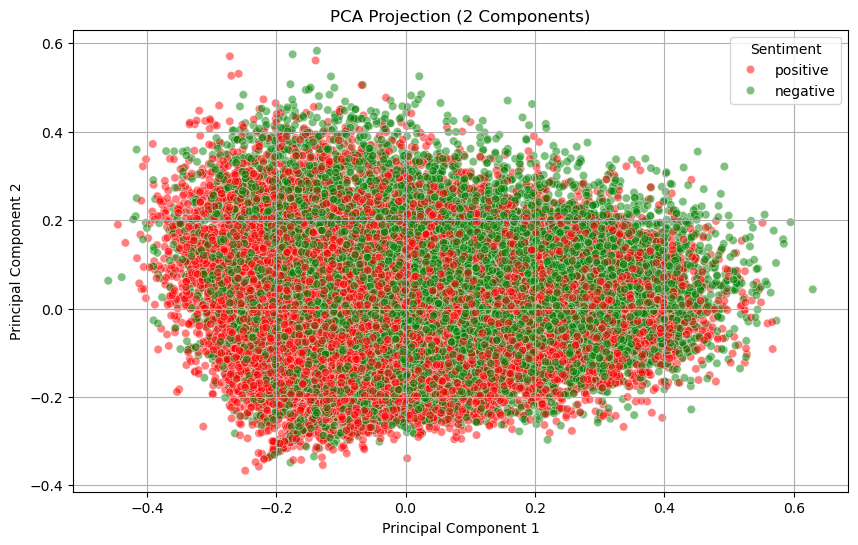

In [14]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_bow_norm.toarray())

# Visualizza con le etichette
pca_df = pd.DataFrame(data=X_train_pca_vis, columns=['PC1', 'PC2'])
pca_df['Sentiment'] = Y_tr 

plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sentiment', palette=['red','green'], alpha=0.5)
plt.title('PCA Projection (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## 4. Applying TFIDF and Reducing Dimensionality on Train and Test Sets with PCA

### 4.1 TFIDF Matrix: Train & Test

In [15]:
#Def. TfidfVectorizer
tfidf= TfidfVectorizer(max_features=50000)

#Tfidf Train set
tfidf_train_data = tfidf.fit_transform(n_train_revw)

#Tfidf Test set
tfidf_test_data = tfidf.transform(n_test_revw)

print('Tfidf_train:', tfidf_train_data.shape)
print('Tfidf_test:', tfidf_test_data.shape)

Tfidf_train: (35000, 50000)
Tfidf_test: (15000, 50000)


### 4.2 TFIDF Matrix:  Data Normalization with L2 Normalization

In [16]:
normalizer = Normalizer()
X_train_tfidf_norm = normalizer.fit_transform(tfidf_train_data)
X_test_tfidf_norm = normalizer.transform(tfidf_test_data)

### 4.3 TFIDF : PCA on Train & Test Data

In [17]:
# PCA
pca = PCA(n_components=500)
X_train_pca_tfidf = pca.fit_transform(X_train_tfidf_norm.toarray())
X_test_pca_tfidf = pca.transform(X_test_tfidf_norm.toarray())

#### PCA 2D Visualization for TFIDF

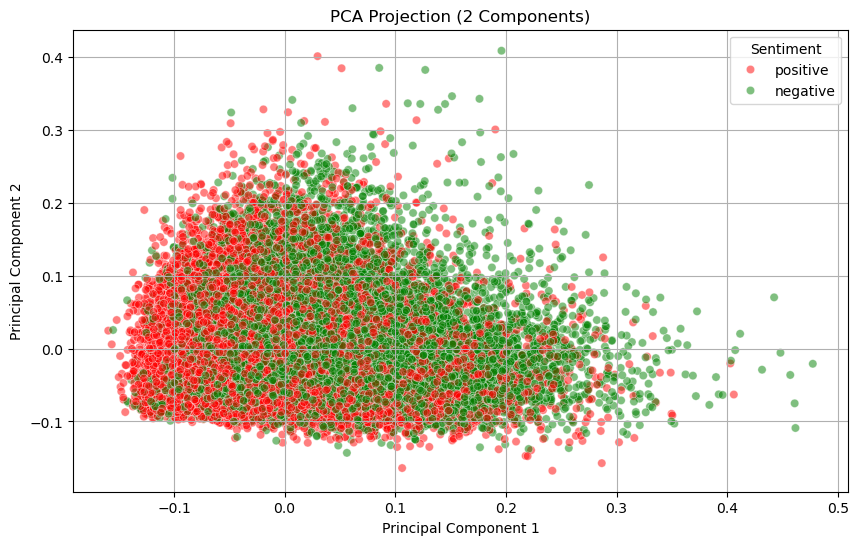

In [18]:
pca = PCA(n_components=2)
X_train_pca_vis = pca.fit_transform(X_train_tfidf_norm.toarray())

# Visualizza con le etichette
pca_df = pd.DataFrame(data=X_train_pca_vis, columns=['PC1', 'PC2'])
pca_df['Sentiment'] = Y_tr 

plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Sentiment', palette=['red','green'], alpha=0.5)
plt.title('PCA Projection (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## 5. Sentiment to Binary format

In [19]:
binaryx = LabelBinarizer()

sentiment_data_binary = binaryx.fit_transform(imdb_dataset['sentiment'])

print(sentiment_data_binary.shape)

(50000, 1)


In [20]:
binary_train_sentiments= sentiment_data_binary[:train_size]
binary_test_sentiments= sentiment_data_binary[train_size:]

print("Train Binary Label Sentiments:\n", binary_train_sentiments.shape)
print("Test Binary Label Sentiments:\n", binary_test_sentiments.shape)

Train Binary Label Sentiments:
 (35000, 1)
Test Binary Label Sentiments:
 (15000, 1)


## 6. Linear Discriminant Analysis (LDA) : Model Training  & Predictions with Test Data

Linear Discriminant Analysis (LDA) is a supervised classification algorithm used to find a linear combination of features that best separates two or more classes.  LDA takes class labels into account and aims to maximize class separability. It projects the input data onto a lower-dimensional space by maximizing the ratio of **between-class variance** to **within-class variance**, thus ensuring optimal class discrimination.

The objective function of LDA is:

$$
J(w) = \frac{w^T S_B w}{w^T S_W w}
$$

Where:

* $S_B$ is the **between-class scatter matrix**,
* $S_W$ is the **within-class scatter matrix**,
* $w$ is the projection vector.

LDA solves this by computing eigenvectors and eigenvalues of the matrix $S_W^{-1} S_B$, selecting the directions that maximize the separation between classes. 


### 6.1 LDA : Model Training & Predictions (TFIDF and BoW)

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_pca_bow, binary_train_sentiments)
lda_pred = lda_model.predict(X_test_pca_bow)

lda_model_tfidf = LinearDiscriminantAnalysis()
lda_model_tfidf.fit(X_train_pca_tfidf, binary_train_sentiments)
lda_pred_tfidf = lda_model.predict(X_test_pca_tfidf)


### 6.2 **BoW** LDA Applications

#### 6.2.1 **BoW** : Plot of Correct/Incorrect Predictions 

Correct predictions: 12943
Incorrect predictions: 2057


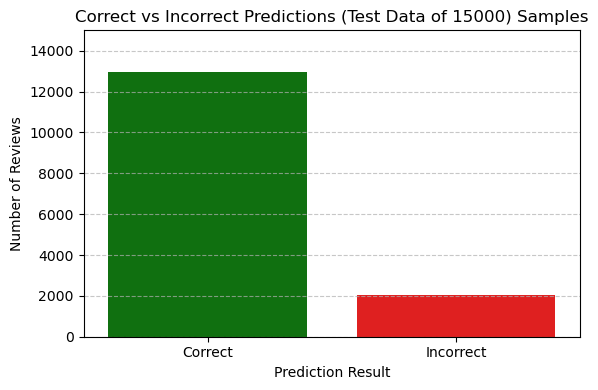

In [27]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in lda_pred[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions BoW:

In [28]:
from IPython.display import display, HTML

sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)




,Review,True Label,Predicted Label,Correct
46499,bigfoot movi tend bad im inclin watch howev good commerci scifi channel decid watch climb expedit he...,negative,negative,True
41475,911 classic exampl cinema verit sort realist documentari thi case new york firemen battl one extraor...,positive,positive,True
48167,realli like thi movi wa funnyboth akshay kumar john abraham brilliant actor think watch thi film lot...,positive,positive,True
35862,thi movi well prove inde unnecessaryalthough line wa kind weird see thi movi sub languag unknown fri...,positive,positive,True
40970,bought thi dvd see highli rank short 20 minut zombi film noth special except music perhapsdont buy e...,negative,negative,True
41706,poor perform sinatra martin hyer grossli underdevelop support charact annoy talki real plot end leav...,negative,negative,True
38017,mom ha one time uncomfort movi watch featur elderli ladi would love nanni becom nastiest mother fing...,positive,negative,False
38781,ive often wonder much casper wa meant childrenwith issu revolv around hi ident thi film lead believ ...,positive,positive,True
38898,dear mr ram gopal varma dont know capac write thi letter neversayhesfinish amitabh bachchan fan sat ...,negative,negative,True
37250,somehow thi film burrow way soft spot heart dont ask happen suppos film featur ed ill sponsor anyth ...,positive,negative,False


#### 6.2.2 **BoW**: Frequency Distribution of Predicted Sentiments 

Predicted Sentiment
Positive    7701
Negative    7299
Name: count, dtype: int64


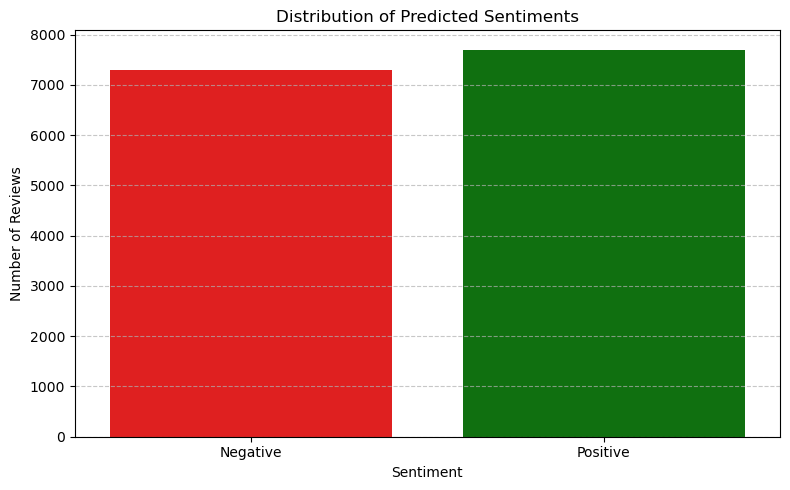

In [29]:
lda_pred_df = pd.DataFrame({'Predicted Sentiment': lda_pred})

label_map = {0: "Negative", 1: "Positive"}
lda_pred_df["Predicted Sentiment"] = lda_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = lda_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=lda_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 6.2.3 **BoW** LDA Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [33]:
lda_pred_label = ['positive' if pred == 1 else 'negative' for pred in lda_pred]


#Accuracy TFIDF
lda_score_bow= accuracy_score(Y_test,lda_pred_label)

print("lda_score_BoW :", lda_score_bow)
print("\n")
BoW_start_time = time.time()
LDA_report_BoW = classification_report(Y_test,lda_pred_label,target_names=['Positive', 'Negative'])
print(LDA_report_BoW)
print("\n")
BoW_end_time = time.time()
bow_RN= BoW_end_time - BoW_start_time
print(f"Runtime for Bag of Words: {bow_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

lda_bow_matrix = confusion_matrix(Y_test_bin,lda_pred, labels=[1, 0])
print("Confusion Matrix for Bag of Words (LDA):")
print(f"True Positive (TP): {lda_bow_matrix[0, 0]}")
print(f"False Positive (FP): {lda_bow_matrix[1, 0]}")
print(f"False Negative (FN): {lda_bow_matrix[0, 1]}")
print(f"True Negative (TN): {lda_bow_matrix[1, 1]}\n")


lda_score_BoW : 0.8628666666666667


              precision    recall  f1-score   support

    Positive       0.87      0.85      0.86      7490
    Negative       0.85      0.88      0.86      7510

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Runtime for Bag of Words: 0.0738 seconds



Confusion Matrix for Bag of Words (Logistic Regression):
True Positive (TP): 6577
False Positive (FP): 1124
False Negative (FN): 933
True Negative (TN): 6366



### 6.3 TFIDF LDA Applications

#### 6.3.1 **TFIDF** : Plot of Correct/Incorrect Predictions

Correct predictions: 7106
Incorrect predictions: 7894


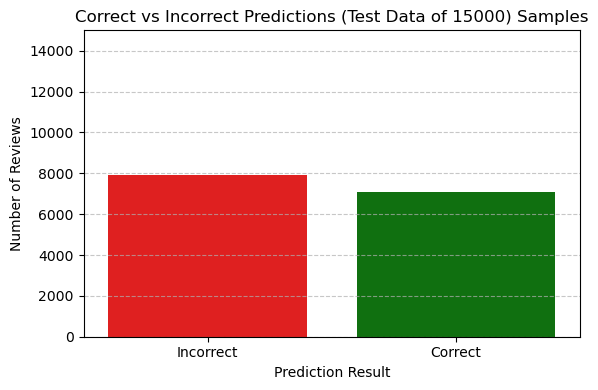

In [34]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in lda_pred_tfidf[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions TFIDF:

In [35]:
sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)

,Review,True Label,Predicted Label,Correct
46499,bigfoot movi tend bad im inclin watch howev good commerci scifi channel decid watch climb expedit he...,negative,positive,False
41475,911 classic exampl cinema verit sort realist documentari thi case new york firemen battl one extraor...,positive,negative,False
48167,realli like thi movi wa funnyboth akshay kumar john abraham brilliant actor think watch thi film lot...,positive,positive,True
35862,thi movi well prove inde unnecessaryalthough line wa kind weird see thi movi sub languag unknown fri...,positive,positive,True
40970,bought thi dvd see highli rank short 20 minut zombi film noth special except music perhapsdont buy e...,negative,negative,True
41706,poor perform sinatra martin hyer grossli underdevelop support charact annoy talki real plot end leav...,negative,positive,False
38017,mom ha one time uncomfort movi watch featur elderli ladi would love nanni becom nastiest mother fing...,positive,negative,False
38781,ive often wonder much casper wa meant childrenwith issu revolv around hi ident thi film lead believ ...,positive,negative,False
38898,dear mr ram gopal varma dont know capac write thi letter neversayhesfinish amitabh bachchan fan sat ...,negative,positive,False
37250,somehow thi film burrow way soft spot heart dont ask happen suppos film featur ed ill sponsor anyth ...,positive,negative,False


#### 6.3.2 **TFIDF**: Frequency Distribution of Predicted Sentiments

Predicted Sentiment
Positive    7710
Negative    7290
Name: count, dtype: int64


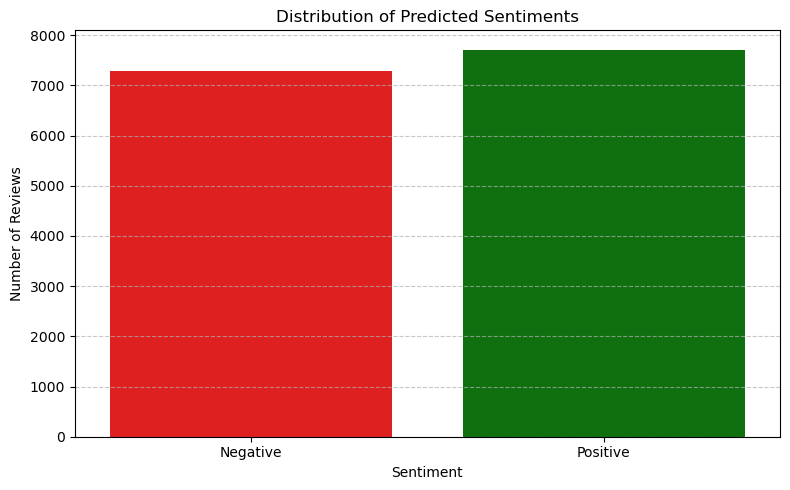

In [36]:
lda_pred_df = pd.DataFrame({'Predicted Sentiment': lda_pred_tfidf})

label_map = {0: "Negative", 1: "Positive"}
lda_pred_df["Predicted Sentiment"] = lda_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = lda_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=lda_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 6.3.3 **TFIDF** LDA Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [37]:
lda_pred_label = ['positive' if pred == 1 else 'negative' for pred in lda_pred_tfidf]


#Accuracy TFIDF
lda_score_tfidf= accuracy_score(Y_test,lda_pred_label)

print("lda_score_tfidf :", lda_score_tfidf)
print("\n")

tfidf_start_time = time.time()
LDA_report_tfidf = classification_report(Y_test,lda_pred_label,target_names=['Positive', 'Negative'])
print(LDA_report_tfidf)
print("\n")

tfidf_end_time = time.time()
tfidf_RN= tfidf_end_time - tfidf_start_time

print(f"Runtime for Tfidf: {tfidf_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

lda_tfidf_matrix = confusion_matrix(Y_test_bin,lda_pred_tfidf, labels=[1, 0])
print("Confusion Matrix for TFIDF (LDA):")
print(f"True Positive (TP): {lda_tfidf_matrix[0, 0]}")
print(f"False Positive (FP): {lda_tfidf_matrix[1, 0]}")
print(f"False Negative (FN): {lda_tfidf_matrix[0, 1]}")
print(f"True Negative (TN): {lda_tfidf_matrix[1, 1]}\n")

lda_score_tfidf : 0.47373333333333334


              precision    recall  f1-score   support

    Positive       0.47      0.46      0.47      7490
    Negative       0.48      0.49      0.48      7510

    accuracy                           0.47     15000
   macro avg       0.47      0.47      0.47     15000
weighted avg       0.47      0.47      0.47     15000



Runtime for Bag of Words: 0.0807 seconds



Confusion Matrix for TFIDF (Logistic Regression):
True Positive (TP): 3663
False Positive (FP): 4047
False Negative (FN): 3847
True Negative (TN): 3443



## 7.0 Evaluation Results and Model Comparasion – LDA

### The **Linear Discriminant Analysis (LDA)** model trained on Bag of Words features achieved the following performance on the test set (15,000 reviews):

| Metric       | Positive   | Negative  |
| ------------ | ---------- | --------- |
| Precision    | 0.87       | 0.85      |
| Recall       | 0.85       | 0.88      |
| F1-Score     | 0.86       | 0.86      |
| **Accuracy** | **0. 0.8629** | (overall) |

**Confusion Matrix (LDA Model + TF-IDF):**

|                     | Predicted Positive | Predicted Negative |
| ------------------- | ------------------ | ------------------ |
| **Actual Positive** | **TP: 6577**       | **FN: 933**        |
| **Actual Negative** | **FP: 1124**       | **TN: 6366**       |

* **True Positives (TP):** 6577 — Positive reviews correctly classified
* **False Positives (FP):** 1124 — Negative reviews incorrectly classified as positive
* **False Negatives (FN):** 933 — Positive reviews incorrectly classified as negative
* **True Negatives (TN):** 6366 — Negative reviews correctly classified

These metrics indicate that the LDA model maintains a **balanced performance** across both sentiment classes. It shows slightly **better recall** on negative reviews, meaning it’s more sensitive in detecting them.

---

#### **Accuracy**

* **Formula:**

  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
* **Interpretation:** Measures the overall percentage of correctly predicted samples. With an accuracy of **86.29%**, this means that approximately **86.3%** of the reviews were correctly classified as **positive** or **negative**..

#### **Precision**

* **Formula:**

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
* **Interpretation:** Indicates how many of the predicted positive reviews were actually positive.

  * A precision of **0.87** for the *positive* class means 87% of reviews classified as positive were indeed positive.
  * It reduces the risk of false positives.

#### **Recall** (Sensitivity)

* **Formula:**

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
* **Interpretation:** Indicates how many actual positive reviews were correctly identified.

  * A recall of **0.85** means 85% of true positive reviews were successfully retrieved.
  * The *negative* class had a slightly better recall of **0.88**, showing strong sensitivity in detecting negative sentiments.

#### **F1-Score**

* **Formula:**

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
* **Interpretation:** Provides a balance between precision and recall.
  An F1-score of **0.86** for both classes indicates a solid balance, which is especially valuable when both false positives and false negatives are equally costly.

---
#### **Computation Time**

* **Runtime** for training and testing: **0.0738 seconds**
  **LDA is not only accurate but also highly efficient**, making it suitable for large datasets.




### The **Linear Discriminant Analysis (LDA)** model trained on TFIDF features achieved the following performance on the test set (15,000 reviews):

| Metric       | Positive   | Negative  |
| ------------ | ---------- | --------- |
| Precision    | 0.47       | 0.48      |
| Recall       | 0.46       | 0.49      |
| F1-Score     | 0.47       | 0.48      |
| **Accuracy** | **0.4737** | (overall) |

**Confusion Matrix (LDA Model + TF-IDF):**

|                     | Predicted Positive | Predicted Negative |
| ------------------- | ------------------ | ------------------ |
| **Actual Positive** | **TP: 3663**       | **FN: 3847**        |
| **Actual Negative** | **FP: 4047**       | **TN: 3443**       |

* **True Positives (TP):** 3663 — Positive reviews correctly classified
* **False Positives (FP):** 4047 — Negative reviews incorrectly classified as positive
* **False Negatives (FN):** 3847 — Positive reviews incorrectly classified as negative
* **True Negatives (TN):** 3443 — Negative reviews correctly classified

---
#### **Accuracy**

* **Formula:**

  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
* **Interpretation:** Accuracy measures the overall correctness of the model's predictions. With a value of **47.37%**, the model performs worse than random guessing in a balanced binary classification problem (50/50), suggesting that LDA may not be effective when applied to TF-IDF features in this context.

#### **Precision**

* **Formula:**

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
* **Interpretation:** Precision reflects how many of the predicted positives were actually positive.

  * For the *positive* class, precision is **0.47**, meaning 47% of predicted positive reviews were indeed positive.
  * The low precision for both classes indicates the model struggles to confidently distinguish sentiment.

#### **Recall** (Sensitivity)

* **Formula:**

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
* **Interpretation:** Recall shows how many actual positive/negative reviews the model successfully identified.

  * For the *positive* class, recall is **0.46**, meaning only 46% of actual positive reviews were detected.
  * The *negative* class performs slightly better with a recall of **0.49**, but still far from ideal.

#### **F1-Score**

* **Formula:**

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
* **Interpretation:** F1-score balances precision and recall.
  With values around **0.47–0.48** for both classes, the model does not exhibit strong performance in either direction. This indicates high uncertainty and inconsistency in predictions.
 


## 8.0 **Conclusion** TFIDF vs BoW with LDA Classification

The LDA model applied to **TF-IDF features** significantly underperforms compared to its use with **Bag of Words (BoW)**. This is reflected in the lower accuracy (47.37%), weaker precision and recall, and a confusion matrix that highlights high misclassification rates.

This performance gap can be explained by the **incompatibility between TF-IDF and LDA’s assumptions**:

* **TF-IDF** adjusts raw word frequencies by penalizing common terms and boosting rare ones. While useful for discriminative models, it disrupts the **true distribution of word occurrence**, which is essential for LDA's probabilistic modeling.
* 
* **LDA** is designed to infer latent topics from the **actual co-occurrence frequencies** of words across documents. It performs better when input with **raw count-based features**, such as BoW, which preserve the natural structure of the data.
  
* Additionally, LDA expects inputs that align with its probabilistic framework, where each document is modeled as a distribution over topics, and each topic as a distribution over words. TF-IDF’s scaling can lead to sparsity and topic dilution.
  
* In contrast, **BoW provides a dense and interpretable input**, capturing how often each word appears, without altering importance based on global frequency—making it a **natural fit** for LDA.

In conclusion, **BoW proves to be highly effective with LDA** because it maintains the integrity of word frequencies that LDA needs to extract meaningful and coherent topics. This compatibility results in significantly better classification performance in sentiment analysis tasks.

